<img src="https://github.com/openEOPlatform/SRR1_notebooks/raw/main/data/images/Sentinel_1.jpg"
     alt="Sentinel-1"
     style="float: left; margin-right: 10px; width:100px" />
# Radar - Sentinel-1: ARD SAR Backscatter

For certain use cases, the readily available preprocessed data collections in the openEO back-ends are not sufficient or inappropriately preprocessed. openEO supports some processes to address very common preprocessing scenarios:

* Atmospheric correction of optical data
* SAR backscatter computation

These processes also offer a number of parameters to customize the processing.

However, please note that these operations can be computationally expensive, so they certainly affect the overall processing time and cost of your final algorithm. Hence, make sure to make an informed decision when using these methods.

In this notebook has been duplicated from an existing sample processing pipeline for Radar ARD on the openEO platform. In this instance, we aim to showcase it with the Copernicus Data Space Ecosystem backend.

## Setup

Import the `openeo` package and connect to the Copernicus Data Space Ecosystem openEO back-end.

In [2]:
import openeo

In [3]:
backend = "openeo.dataspace.copernicus.eu"
conn = openeo.connect(backend).authenticate_oidc()

Authenticated using refresh token.


### On-demand SAR Backscatter

Data from synthetic aperture radar (SAR) sensors requires significant preprocessing to be calibrated and normalized. This is referred to as backscatter computation and is provided in the openEO by the [`sar_backscatter` process](https://docs.openeo.cloud/processes/#sar_backscatter).

The radiometric correction coefficient used in this example is `sigma0-ellipsoid`.

## Specify area of interest, temporal extent, polarization

In [4]:
spatial_extent = {
    "west": 11.293602,
    "east": 11.382866,
    "south": 46.460163,
    "north": 46.514768,
    "crs": "EPSG:4326",
}

s1 = conn.load_collection(
    "SENTINEL1_GRD",
    spatial_extent=spatial_extent,
    bands=["VV", "VH"],
    temporal_extent=["2021-01-01", "2021-01-08"],
    properties={"sat:orbit_state": lambda od: od == "ASCENDING"},
)

## Apply openEO processes

Here we apply both the SAR backscattering processes on the datacube and then convert it from linear to dB scale.

In [5]:
s1_scatter = s1.sar_backscatter(
    coefficient="sigma0-ellipsoid", elevation_model="COPERNICUS_30"
)
s1bs = s1_scatter.apply(lambda x: 10 * x.log(base=10))

## Execution 

Since our area of interest is small, a direct request is preferred. Nevertheless, please note that this approach will not return the JSON metadata. If you want JSON metadata along with the result you can choose the Batch job-based method too.

Note that this step automatically adds the save_result process at the end based on the output format we choose.

In [6]:
%time s1bs.download("sar_bs.nc")

CPU times: user 13.6 ms, sys: 22.7 ms, total: 36.3 ms
Wall time: 28 s


## Output visualization

In [7]:
import xarray as xr

S1_ard = xr.open_dataset("sar_bs.nc")
S1_ard

<xarray.Dataset>
Dimensions:  (t: 1, x: 704, y: 628)
Coordinates:
  * t        (t) datetime64[ns] 2021-01-03
  * x        (x) float64 6.759e+05 6.76e+05 6.76e+05 ... 6.83e+05 6.83e+05
  * y        (y) float64 5.154e+06 5.154e+06 5.154e+06 ... 5.148e+06 5.148e+06
Data variables:
    crs      |S1 ...
    VV       (t, y, x) float32 ...
    VH       (t, y, x) float32 ...
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform

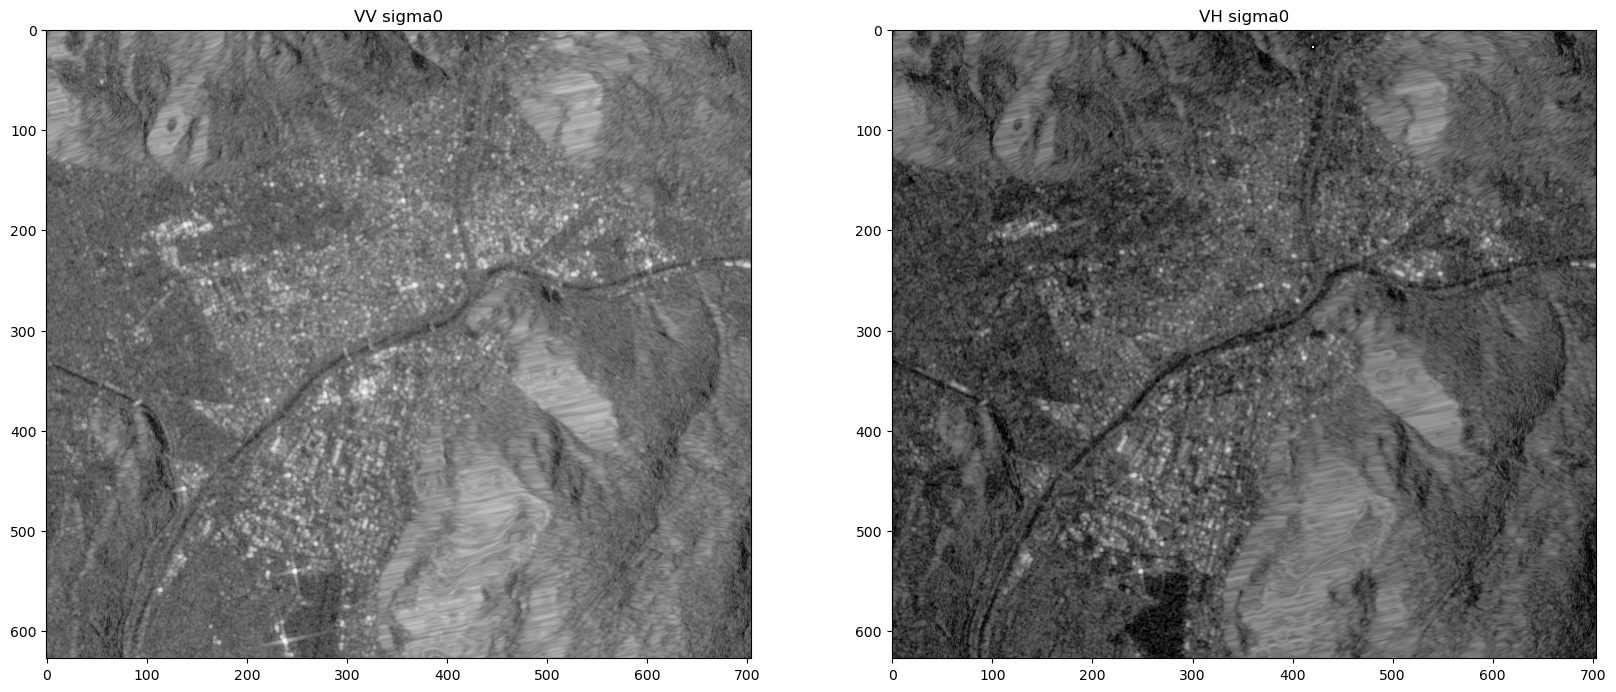

In [8]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
ax1.imshow(S1_ard.VV[0].values, cmap="Greys_r", vmin=-30, vmax=30)
ax1.set_title("VV sigma0")
ax2.imshow(S1_ard.VH[0].values, cmap="Greys_r", vmin=-30, vmax=30)
ax2.set_title("VH sigma0")
plt.show()